# <span style="color: Teal; font-weight: bold">Modeling</span>

## <span style="color: Teal; font-weight: bold">Setup</span>

In [1]:
# Python library import block
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Encoders and other important functions
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

# Custom functions from module
from extra_functions import cprint # colored print; makes some output a bit easier to read
from extra_functions import plotColumnCounts # bar plots (categorical) or histograms (numerical) for columns
from extra_functions import trim_feature # remove categories from a model if the total proportion represented is under a certain threshold (default: 1%)
from extra_functions import convert_range_to_avg

In [2]:
# import data objects for easy indexing
mainline_model = ['website_bool', 'support_url_bool', 'supported_languages_int', 'full_audio_languages_int', 'tags_count']
target_features = ['metacritic_bool', 'recommendations_bool', 'estimated_owners_tri', 'price_sqrt']
target_transformation = {'two_stage_model_features': ['metacritic_score', 'recommendations'],
                         'polychotomize_features': 'estimated_owners',
                         'square_root': 'price'}

In [3]:
# import data from .csv files
df = pd.read_csv('data/model_mainline games.zip', compression = 'zip').set_index('AppID')
mainline_df = df[mainline_model]
catgen_df = pd.read_csv('data/model_catgen.csv').set_index('AppID')
tags_num_df = pd.read_csv('data/model_tags_numeric.csv').set_index('index')
tags_bool_df = pd.read_csv('data/model_tags_bool.csv').set_index('index')

## <span style="color: Teal; font-weight: bold">Preparation</span>

I have four predictive models that I can test, that may be able to be combined. At the moment, I will keep them separate to reduce dimensionality during modeling.

- Mainline model: DF with 5 features realted to whether gaves have a website, support information, and how many langauges they have available.
- Categories/Genres model: DF with 64 game categories and genres. All Boolean, so 1/0.
- Tags - Numeric model: DF with 30 features, consisting of the 30 most present game tags. This has the raw number of tags per game.
- Tags - Boolean model: DF with 30 features, like the 'Tags - Numeric model', but all values are 1/0.

After initial modeling, I may take the highest-performing features and run one final model, including everything.

I have four possible target features:
- `metacritic_bool`: Boolean representing whether a game has a metacritic score. (This may not be useful; very imbalanced class.)
- `recommendations_bool`: Boolean representing whether a game has any recommendations.
- `estimated_owners_tri`: A polychotomized variable representing number of owners.
  - 0: 0 - 20000
  - 1: 20000 - 50000
  - 2: 50001+
- `price_sqrt`: The square root of the price (transformed to make the variable a bit more normal). Value between sqrt(10) and 10.

**Strategy**:
There are two classes of models I will be using.
- Regression: To predict `price_sqrt`. Use multiple regression for these to begin with.
- Classification: To predict the other targets.
    - Binary classification: `metacritic_bool`, `recommendations_bool`. The best model (logistic regression vs. decision tree) may depend on the predictive model.
    - Multiclass classification: `estimated_owners_tri`. The best model (logistic regression vs. decision tree) may depend on the predictive model.

For modeling, I will use cross-validation methods, and have a final holdout sample to see how well the model performs.

**Transformation steps**
The following steps will be conducted to transform and prep the data for modeling:

1) Set aside 10% of the data for testing final models
2) Set up modeling pipelines
3) Model data

### <span style="color: Teal; font-weight: bold">Feature Transformation Prep

In [4]:
target_df = df[target_features]
target_df.head()

,metacritic_bool,recommendations_bool,estimated_owners_tri,price_sqrt
AppID,,,,
359550,0,1,2,4.471018
252490,1,1,2,6.323765
1091500,1,1,2,5.476313
553850,0,1,2,6.323765
1245620,1,1,2,7.745321


In [5]:
X_main, X2_main, X_catgen, X2_catgen, X_tags_num, X2_tags_num, X_tags_bool, X2_tags_bool, y_train, y_test  = train_test_split(mainline_df, catgen_df, tags_num_df, tags_bool_df, target_df, test_size = 0.1, random_state = 42)
print(X_main.shape[0])
print(X2_main.shape[0])

14686
1632


### <span style="color: Teal; font-weight: bold">Modeling Pipelines</span>

Create column transformers and pipelines for each of the four predictive models.

In [6]:
main_ct = ColumnTransformer(
    transformers = [('std', StandardScaler(), X_main.columns)],
    remainder = 'passthrough')
tags_num_ct = ColumnTransformer(
    transformers = [('std', StandardScaler(), X_tags_num.columns)],
    remainder = 'passthrough')

## <span style="color: Teal; font-weight: bold">Models - Linear Regression</span>

In [7]:
main_pipe_ridge = Pipeline([('xform', main_ct), ('ridge', Ridge())])
catgen_pipe_ridge = Pipeline([('poly', PolynomialFeatures(degree = 2, include_bias = False)), ('ridge', Ridge())])
tags_num_ridge = Pipeline([('xform', tags_num_ct,), ('ridge', Ridge())])
tags_bool_ridge = Pipeline([('ridge', Ridge())])

### <span style="color: Teal; font-weight: bold">Prices</span>

#### <span style="color: Teal; font-weight: bold">Modeling</span>

In [8]:
target_features

['metacritic_bool',
 'recommendations_bool',
 'estimated_owners_tri',
 'price_sqrt']

In [9]:
best_price_features = {}

In [10]:
## Mainline model
ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

main_grid_ridge = GridSearchCV(main_pipe_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
main_grid_ridge.fit(X_main, y_train['price_sqrt'])
main_grid_ridge.score(X2_main, y_test['price_sqrt'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.04030831769232457

In [11]:
main_ridge_results = pd.DataFrame({'feature': main_grid_ridge.feature_names_in_, 'coef': main_grid_ridge.best_estimator_['ridge'].coef_}).set_index('feature')
main_ridge_results

,coef
feature,
website_bool,0.006020
support_url_bool,0.077608
supported_languages_int,0.181270
full_audio_languages_int,-0.007469
tags_count,-0.005521


In [12]:
best_price_features['main'] = list(main_ridge_results.index[np.abs(main_ridge_results['coef']) > .10])
best_price_features

{'main': ['supported_languages_int']}

In [13]:
## Catgen model
ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

catgen_grid_ridge = GridSearchCV(catgen_pipe_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
catgen_grid_ridge.fit(X_catgen, y_train['price_sqrt'])
catgen_grid_ridge.score(X2_catgen, y_test['price_sqrt'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.2221865284151502

In [14]:
catgen_ridge_results = pd.DataFrame({'feature': catgen_grid_ridge.best_estimator_.named_steps['poly'].get_feature_names_out(), 'coef': catgen_grid_ridge.best_estimator_['ridge'].coef_}).set_index('feature')
catgen_ridge_results.sort_values('coef',ascending=False)

,coef
feature,
categories_single-player categories_multi-player,0.234796
genres_indie genres_casual,0.203930
genres_indie genres_early_access,0.161864
categories_remote_play_together genres_simulation,0.156313
categories_full_controller_support categories_steam_achievements,0.154739
categories_steam_achievements categories_partial_controller_support,0.151647
categories_online_pvp categories_shared/split_screen,0.146143
categories_family_sharing genres_simulation,0.144239
categories_single-player categories_steam_cloud,0.136016


In [15]:
best_price_features['catgen'] = list(catgen_ridge_results.index[np.abs(catgen_ridge_results['coef']) > .10])
best_price_features

{'main': ['supported_languages_int'],
 'catgen': ['categories_single-player',
  'categories_steam_trading_cards',
  'categories_family_sharing',
  'categories_remote_play_together',
  'genres_indie',
  'genres_early_access',
  'categories_single-player^2',
  'categories_single-player categories_multi-player',
  'categories_single-player categories_online_pvp',
  'categories_single-player categories_steam_cloud',
  'categories_single-player categories_remote_play_together',
  'categories_multi-player categories_remote_play_together',
  'categories_online_pvp categories_shared/split_screen',
  'categories_online_pvp genres_adventure',
  'categories_online_pvp genres_casual',
  'categories_full_controller_support categories_steam_achievements',
  'categories_full_controller_support genres_indie',
  'categories_steam_trading_cards^2',
  'categories_steam_trading_cards categories_remote_play_together',
  'categories_steam_trading_cards genres_indie',
  'categories_steam_achievements categor

In [16]:
## tags_num model
ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

tags_num_grid_ridge = GridSearchCV(tags_num_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
tags_num_grid_ridge.fit(X_tags_num, y_train['price_sqrt'])
tags_num_grid_ridge.score(X2_tags_num, y_test['price_sqrt'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.04634650007932384

In [17]:
tags_num_ridge_results = pd.DataFrame({'feature': tags_num_grid_ridge.feature_names_in_, 'coef': tags_num_grid_ridge.best_estimator_['ridge'].coef_}).set_index('feature')
tags_num_ridge_results.sort_values('coef', ascending=False)

,coef
feature,
Action,0.077587
Anime,0.074692
Multiplayer,0.073007
Singleplayer,0.072367
Simulation,0.064975
Action-Adventure,0.029731
Open World,0.028019
Strategy,0.021142
Story Rich,0.019154


In [18]:
# Don't add anything from this model

In [19]:
## tags_bool model
ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

tags_bool_grid_ridge = GridSearchCV(tags_bool_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
tags_bool_grid_ridge.fit(X_tags_bool, y_train['price_sqrt'])
tags_bool_grid_ridge.score(X2_tags_bool, y_test['price_sqrt'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.11673313002003383

In [20]:
tags_bool_grid_results = pd.DataFrame({'feature': tags_bool_grid_ridge.feature_names_in_, 'coef': tags_bool_grid_ridge.best_estimator_['ridge'].coef_}).set_index('feature')
tags_bool_grid_results.sort_values('coef', ascending=False)

,coef
feature,
Anime,0.284435
Multiplayer,0.219815
Singleplayer,0.189899
Simulation,0.158487
Open World,0.136727
Third Person,0.120699
Story Rich,0.120335
Co-op,0.066056
RPG,0.063855


In [21]:
best_price_features['tags_bool'] = list(tags_bool_grid_results.index[np.abs(tags_bool_grid_results['coef']) > .10])
best_price_features

{'main': ['supported_languages_int'],
 'catgen': ['categories_single-player',
  'categories_steam_trading_cards',
  'categories_family_sharing',
  'categories_remote_play_together',
  'genres_indie',
  'genres_early_access',
  'categories_single-player^2',
  'categories_single-player categories_multi-player',
  'categories_single-player categories_online_pvp',
  'categories_single-player categories_steam_cloud',
  'categories_single-player categories_remote_play_together',
  'categories_multi-player categories_remote_play_together',
  'categories_online_pvp categories_shared/split_screen',
  'categories_online_pvp genres_adventure',
  'categories_online_pvp genres_casual',
  'categories_full_controller_support categories_steam_achievements',
  'categories_full_controller_support genres_indie',
  'categories_steam_trading_cards^2',
  'categories_steam_trading_cards categories_remote_play_together',
  'categories_steam_trading_cards genres_indie',
  'categories_steam_achievements categor

In [22]:
# create a catgen df with polynomial features, to concatenate for main model
catgen_xform = pd.DataFrame(PolynomialFeatures(degree = 2, include_bias = False).fit_transform(catgen_df), columns=catgen_grid_ridge.best_estimator_.named_steps['poly'].get_feature_names_out(), index = catgen_df.index)

main_model_final = pd.concat([mainline_df[best_price_features['main']], catgen_xform[best_price_features['catgen']], tags_bool_df[best_price_features['tags_bool']]], axis = 1)
#pd.concat([X_main[best_price_features['main']], catgen_xform[best_price_features['catgen']], X_tags_bool[best_price_features['tags_bool']]], axis = 1)

main_colcheck = []
for temp_model_type in best_price_features.values():
    if isinstance(temp_model_type, list):
        for temp_colname in temp_model_type:
            main_colcheck.append(temp_colname in main_model_final.columns)
    else:
        main_colcheck.append(temp_model_type in main_model_final.columns)

all(main_colcheck)

True

In [23]:
# run GridSearchCV for ridge model
X_ridge_final, X2_ridge_final, y_ridge_train, y_ridge_test = train_test_split(main_model_final, df['price_sqrt'], test_size = 0.1, random_state = 42)

### pipeline: (1) polynomial transformation for catgen, (2) standard scaler for all, (3) ridge regression
main_final_ct = ColumnTransformer(
    transformers = [('std', StandardScaler(), X_ridge_final.columns)],
    remainder = 'passthrough')

main_final_pipe_ridge = Pipeline([('xform', main_final_ct), ('ridge', Ridge())])

ridge_parameters = {'ridge__alpha': 10**np.linspace(-3, 3, 7)}

main_final_grid_ridge = GridSearchCV(main_final_pipe_ridge, ridge_parameters, cv = 5, scoring='r2', verbose=1)
main_final_grid_ridge.fit(X_ridge_final, y_ridge_train)
main_final_grid_ridge.score(X2_ridge_final, y_ridge_test)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.24789997048788182

In [24]:
main_final_ridge_rmse = np.sqrt(mean_squared_error(main_final_grid_ridge.predict(X2_ridge_final), y_ridge_test))

print(f"RMSE: {main_final_ridge_rmse} || RMSE in terms of original dollar price: ${round(main_final_ridge_rmse**2,4)}")

RMSE: 0.9205044309140943 || RMSE in terms of original dollar price: $0.8473


#### <span style="color: Teal; font-weight: bold">Summary</span>

The RMSE of this final model for predicting `price_sqrt` is ~0.92. The unit of `price_sqrt` is the square root of dollar price; converting the units to original dollar price, the model's RMSE corresponds to 0.92^2, or $0.8473. This seems like a small margin of error given that the R^2 value for the model is only 0.24--not bad, but not perfect at all.

<Axes: >

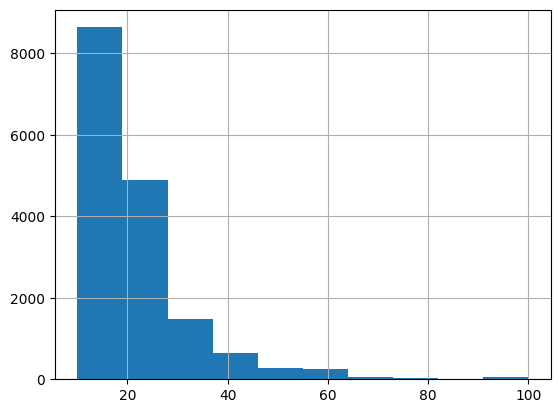

In [25]:
df['price'].hist()

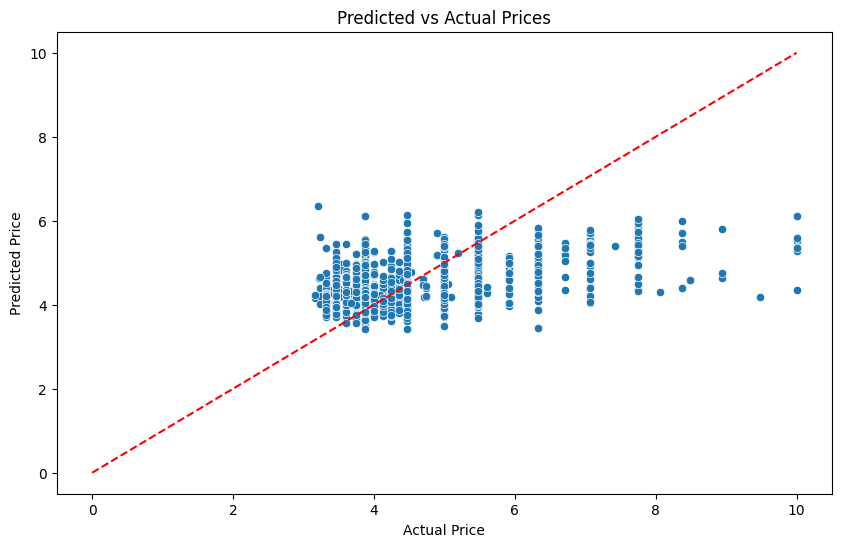

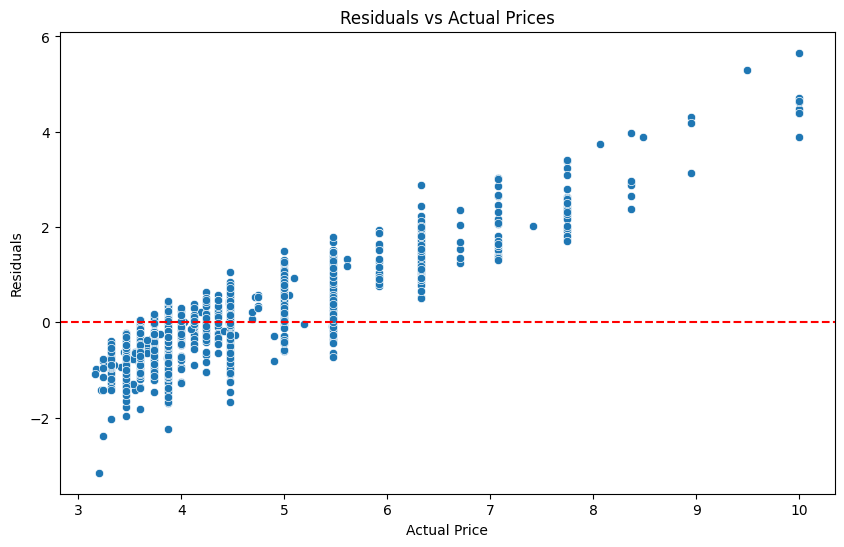

In [26]:
# plot the model's residuals
main_final_ridge_resid = pd.DataFrame({'Actual': y_ridge_test, 'Predicted': main_final_grid_ridge.predict(X2_ridge_final), 'Residuals': y_ridge_test - main_final_grid_ridge.predict(X2_ridge_final)})

plt.figure(figsize = (10,6))
sns.scatterplot(x='Actual', y='Predicted', data=main_final_ridge_resid)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices')
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Residuals', data=main_final_ridge_resid)
plt.axhline(0, color='red', linestyle='--')  # Line at zero
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Prices')
plt.show()

The model seems to essentially be guessing the mean; there's not enough variance in the predicted values.

## <span style="color: Teal; font-weight: bold">Models - Classification</span>

### <span style="color: Teal; font-weight: bold">Metacritic (Boolean)</span>

In [27]:
main_ct = ColumnTransformer(
    transformers = [('std', StandardScaler(), X_main.columns)],
    remainder = 'passthrough')
tags_num_ct = ColumnTransformer(
    transformers = [('std', StandardScaler(), X_tags_num.columns)],
    remainder = 'passthrough')

main_pipe_log = Pipeline([('xform', main_ct), ('log', LogisticRegression())])
catgen_pipe_log = Pipeline([('log', LogisticRegression())])
tags_num_log = Pipeline([('xform', tags_num_ct,), ('log', LogisticRegression())])
tags_bool_log = Pipeline([('log', LogisticRegression())])

### <span style="color: Teal; font-weight: bold">Recommendations (Boolean)</span>

### <span style="color: Teal; font-weight: bold">Estimated Owners (Multiclass)</span>

TODO
- If OLS regression doesn't work for tag_count, could try negative binomial regression
- Use the Matthews correlation coefficient (example: <a href="https://substantial.com/insights/creating-steamml-predicting-game-success">here</a>) to evaluate success?